In [1]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import os, cv2, torch

## Comparison with SOTA Methods (R1's W2)

In [2]:
# bring all datas
cam_H, cam_W, wvl_n = 580, 890, 24

# illumination
illum_ours = np.load('./rebuttal/SOTA_methods/illum_ours.npy')
illum_deep = np.load('./rebuttal/SOTA_methods/illum_deep.npy')
illum_deep = illum_deep/illum_deep.max()

# captured image
captured_img_ours = np.load('./rebuttal/SOTA_methods/cam_N_img_ours.npy')
captured_img_deep = np.load('./rebuttal/SOTA_methods/cam_N_img_deep.npy')[:,:,0]

# datas
depth = np.load('./rebuttal/SOTA_methods/depth.npy').squeeze().reshape(cam_H, cam_W)
occ = np.load('./rebuttal/SOTA_methods/occ.npy').squeeze().reshape(cam_H, cam_W)
hyp = np.load('./rebuttal/SOTA_methods/hyp.npy').squeeze().reshape(cam_H, cam_W, wvl_n)
hyp_shading = np.load('./rebuttal/SOTA_methods/hyp_shading.npy')
normal = np.load('./rebuttal/SOTA_methods/normal.npy').squeeze().reshape(3, cam_H, cam_W).transpose(1,2,0)
cam_coord = np.load('./rebuttal/SOTA_methods/cam_coord.npy').squeeze().reshape(cam_H, cam_W, 3)

# correspondence
cond = np.load('./rebuttal/SOTA_methods/cond.npy').squeeze()
new_idx = np.load('./rebuttal/SOTA_methods/new_idx.npy')
zero_uv1 = np.load('./rebuttal/SOTA_methods/zero_uv1.npy').squeeze().reshape(3, cam_H, cam_W).transpose(1,2,0)

# crf
cam_crf = torch.tensor(np.load('./dataset/image_formation/CRF_update.npy')[::2]) # 430nm - 660nm

### [4] Method

#### Psf processing

In [3]:
import torchvision
import torchvision.transforms as tf

# bring psf
psfs = loadmat('./rebuttal/SOTA_methods/psfs_97x97_norm.mat')['psfs'].squeeze()[:,1:] # depth, wvl, H, W
# wavelength 420nm ~ 660nm
wvls = np.arange(430, 670,10)

print('wavelengths :', len(wvls))
print('psfs shape:', psfs.shape)

wavelengths : 24
psfs shape: (7, 24, 97, 97)


In [4]:
# resize psf

# Original PSF size
psf_height, psf_width = 97, 97

# Final matrix size
final_height, final_width = 580, 890

# Create a zero matrix of the final size
padded_matrix = np.zeros((final_height, final_width))

# Calculate the starting position for the PSF (top-left corner)
start_height = (final_height - psf_height) // 2
start_width = (final_width - psf_width) // 2


resized_psf = np.zeros(shape=(7, 24, cam_H, cam_W))

for d in range(psfs.shape[0]):
    for w in range(psfs.shape[1]):
        # Assuming we have a PSF matrix named 'psf', we would insert it like this:
        # This is just an example. You should replace this with your actual PSF data.
        psf = psfs[d,w]  # Example PSF
        padded_matrix[start_height:start_height + psf_height, start_width:start_width + psf_width] = psf

        # Check the position of the inserted PSF (it should be centered)
        resized_psf[d,w] = padded_matrix

#### Original Code..

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

for p in range(7):
    print('%02d-th PSF'%p)
    psf = psfs[p]

    fig, axes = plt.subplots(5, 5, figsize=(10, 10))

    for ax, img in zip(axes.flat, psf):
        im = ax.imshow(img, cmap='gray')  # You can change 'gray' to another colormap if your images are not grayscale
        ax.axis('off')  # Hide axes ticks
    
        # Create an axis for the colorbar next to the current axis
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        
        # Add the colorbar to the created axis
        plt.colorbar(im, cax=cax)
    
    plt.suptitle('%02d-th PSF'%p)
    plt.tight_layout()  # Adjust subplots to fit in the figure area
    plt.show()

In [6]:
import torch

def hs2rgb(rad_x, wvls, crf, output_mode_HWC=False, gamma=2.2, normalize=False, WB=True, rawRGB2sRGB_mat=None, vmin=0,vmax=1):
    # conversion_mat: K x 3, where K is the number of the hyperspectral channels
    # rad_x: R x C x N, where N is the numer of spectral channels
    # crf: N x 3
    # wvls: N x 1

    if type(rad_x) == torch.Tensor:
        # nCh, R, C
        rad_x = rad_x.data.cpu().numpy()
        rad_x = np.transpose(rad_x, (1, 2, 0))

    rgb = np.zeros((rad_x.shape[0], rad_x.shape[1], 3))
    for i in range(len(wvls)):
        rgb[:,:,0] += rad_x[:,:,i] * crf[i, 0]
        rgb[:,:,1] += rad_x[:,:,i] * crf[i, 1]
        rgb[:,:,2] += rad_x[:,:,i] * crf[i, 2]


    if WB:
        rgb_sum = crf.sum(0)
        rgb[:, :, 0] /= rgb_sum[0]
        rgb[:, :, 1] /= rgb_sum[1]
        rgb[:, :, 2] /= rgb_sum[2]

    # ==============
    # raw RGB 2 sRGB
    if rawRGB2sRGB_mat is not None:
        [R,C,_]=rgb.shape
        rgb = (rawRGB2sRGB_mat@(rgb.reshape([R*C,3]).transpose((1,0)))).transpose((1,0)).reshape([R,C,3])
    # ==============

    if normalize:
        rgb = (rgb-vmin)/(vmax-vmin)

    rgb[rgb > 1] = 1
    rgb[rgb < 0] = 0

    rgb = rgb**(1/gamma)

    if output_mode_HWC:
        return rgb
    else:
        return np.transpose(rgb, (2,0,1))

def putLabel(im, label):
    # im: (nCh,R,C)
    im2 = cv2.putText(im.transpose((1, 2, 0)), text=label,
                org=(5, im.shape[1]-5),
                       fontFace=cv2.FONT_HERSHEY_PLAIN, fontScale=1.5, color=(255,255,255), thickness=2)
    return im2.transpose((2,0,1))

# img: B x D x C x N x M
# wvls: [mm]
# output: 1 x 3 x DN x CM
def vis_HSD_im(img, depths, wvls, crf,
               title='comp', save=False, save_fn='',
               gamma_correction=True,
               display=False, normalize=False, showLabels=False, measure=False, gamma=2.2, scaler=1,psf_rgb=False
               ):

    convert_rgb2gray = True

    if type(img) is torch.Tensor:
        img = img.data.cpu().numpy()

    padding_row = 3
    padding_col = 3

    if psf_rgb:
        B, D, C, _, N, M = img.shape
    else:
        B, D, C, N, M = img.shape

    rows = D + 1  # 1 for RGB visualization
    cols = C + 1  # 1 for RGB visualization

    # RGB
    vis_h = (padding_row + N)*rows + padding_row
    vis_w = (padding_col + M)*cols + padding_col
    img_vis = np.zeros(shape=(3, vis_h, vis_w), dtype=np.float32)
    img_vis[:] = 1


    # crf_scaler = crf / crf_max_rgb
    crf_rgb_sum = crf.sum(0)

    for d in range(D):

        # per-depth PSF
        if psf_rgb:
            img_HS_rgb = img[0,d,:,:,:,:].sum(axis=0)
            img_HS_rgb[0,...] /= crf_rgb_sum[0]
            img_HS_rgb[1,...] /= crf_rgb_sum[1]
            img_HS_rgb[2,...] /= crf_rgb_sum[2]

            if normalize:
                img_HS_rgb = img_HS_rgb / img_HS_rgb.max()


        else:
            img_HS = img[0,d,:,:,:].transpose((1,2,0))
            if measure:
                img_HS_rgb = hs2rgb(img_HS, wvls, crf, normalize=False, gamma=1) # gamma will be applied in the end
            else:
                img_HS_rgb = hs2rgb(img_HS, wvls, crf, normalize=normalize, gamma=1) # gamma will be applied in the end

        pos_img_y = padding_row + (padding_row + N) * (d+1)
        pos_img_x = padding_col + (padding_col + M) * 0
        if showLabels:
            img_HS_rgb = putLabel(img_HS_rgb, '%.2fm'%depths[d])
        img_vis[:, pos_img_y:(pos_img_y + N), pos_img_x:(pos_img_x + M)] = img_HS_rgb

        for c in range(C):

            # per-spectrum PSF
            if psf_rgb:
                img_D_rgb = img[0,:,c,:,:,:].sum(axis=0)
                img_D_rgb[0,...] /= crf_rgb_sum[0]
                img_D_rgb[1,...] /= crf_rgb_sum[1]
                img_D_rgb[2,...] /= crf_rgb_sum[2]

                if normalize:
                    img_D_rgb = img_D_rgb / img_D_rgb.max()

            else:
                img_D = np.zeros((N, M, C))
                for d2 in range(D):
                    img_D[:,:,c] += img[0,d2,c,:,:]
                if measure:
                    img_D_rgb = hs2rgb(img_D, wvls, crf, normalize=False, gamma=1) # gamma will be applied in the end
                else:
                    img_D_rgb = hs2rgb(img_D, wvls, crf, normalize=normalize, gamma=1) # gamma will be applied in the end

            if showLabels:
                img_D_rgb = putLabel(img_D_rgb, '%dnm' % np.round(wvls[c]))

            pos_img_y = padding_row + (padding_row + N) * 0
            pos_img_x = padding_col + (padding_col + M) * (c+1)
            img_vis[:, pos_img_y:(pos_img_y + N), pos_img_x:(pos_img_x + M)] = img_D_rgb

            # each PSF
            pos_img_y = padding_row + (padding_row + N) * (d+1)
            pos_img_x = padding_col + (padding_col + M) * (c+1)

            if psf_rgb:
                img_cur = img[0, d, c, ...].copy()
                img_cur[0,...] /= crf_rgb_sum[0]
                img_cur[1,...] /= crf_rgb_sum[1]
                img_cur[2,...] /= crf_rgb_sum[2]

                if convert_rgb2gray:
                    arg_max_i = np.argmax(np.mean(img_cur,axis=(1,2)))
                    img_cur_gray = img_cur[arg_max_i, ...].copy()
                    img_cur[0,...] = img_cur_gray
                    img_cur[1,...] = img_cur_gray
                    img_cur[2,...] = img_cur_gray

                if normalize:
                    img_cur = img_cur / img_cur.max()
                img_vis[:, pos_img_y:(pos_img_y + N), pos_img_x:(pos_img_x + M)] = img_cur

            else:
                img_c = img[0, d, c, ...]
                img_vis[:, pos_img_y:(pos_img_y + N), pos_img_x:(pos_img_x + M)] = img_c

                if measure:
                    img_c_r = img_c * crf[c,0]
                    img_c_g = img_c * crf[c,1]
                    img_c_b = img_c * crf[c,2]
                    img_c = np.concatenate((np.expand_dims(img_c_r,0),
                                            np.expand_dims(img_c_g,0),
                                            np.expand_dims(img_c_b,0)),
                                           axis=0)
                    img_vis[:, pos_img_y:(pos_img_y + N), pos_img_x:(pos_img_x + M)] = img_c
                else:
                    if normalize:
                        img_c = img_c / img_c.max()
                    img_vis[:, pos_img_y:(pos_img_y + N), pos_img_x:(pos_img_x + M)] = np.expand_dims(img_c, 0).repeat(3, 0)

    if measure and normalize:
        img_vis = scaler * img_vis / img_vis.max()


    if gamma_correction:
        img_vis = np.power(img_vis, 1 / gamma)

    img_vis = img_vis.transpose((1,2,0))

    if display:
        plt.figure(title, figsize=(15,8), dpi=500)
        plt.imshow(img_vis)
        x_tickmarks = padding_row + N/2 + (padding_row + N) * (np.arange(1,C+1))
        y_tickmarks = padding_row + M/2 + (padding_row + M) * (np.arange(1,D+1))
        plt.yticks(y_tickmarks, ['%.2f'%x for x in depths])
        plt.xticks(x_tickmarks, [str(np.int(np.round(x/1e-9))) for x in wvls])
        axes = plt.axes()
        plt.gca().spines['left'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['bottom'].set_visible(False)
        axes.set_ylim([0,img_vis.shape[1]])
        axes.set_ylim([0, img_vis.shape[0]])
        axes.invert_yaxis()
        axes.xaxis.tick_top()
        axes.xaxis.set_label_position('top')
        plt.xlabel('wavelength [nm]')
        plt.ylabel('depth [m]')
        plt.tick_params(axis=u'both', which=u'both', length=0)

    if save:
        cv2.imwrite(save_fn, img_vis[...,::-1]*255)

    img_vis = np.expand_dims(img_vis.transpose((2,0,1)),0)

    return img_vis

In [16]:
import torchvision
import torch.fft as fft
resize = torchvision.transforms.Resize(97)

def apply_srf(hsi, srf):
    """Applies the spectral response function to the hyperspectral image to get the RGB image.

    Args:
        hsi: A multi-dimensional tensor for the hyperspectral image. Shape could be 
            [B, K, M, N], where B is the batch dimension (could be None or 1). K is 
            the spectral dimension. M and N are the spatial dimensions.
        srf: A 3D tensor for the sensor spectral response function. Shape should be
            [K, C], where C = 1 for monochromatic sensor, and C = 3 for color sensor.
    """

    rgb = torch.sum(hsi.unsqueeze(-1) * srf.unsqueeze(1).unsqueeze(2), -4)
    rgb = torch.permute(rgb, (0, 3, 1, 2))

    return rgb

#### Weight Map

In [5]:
# calculate weight map V1

depth_range = np.array([0.40,0.46,0.55,0.67,0.86,1.20,2.00])
weight_map = np.zeros(shape=(len(depth_range), cam_H* cam_W))

for i in range(len(depth.reshape(-1))):
    if np.any(np.isclose(np.round(depth.reshape(-1)[i], 2), depth_range)):
        idx = np.where(abs(depth_range - np.round(depth.reshape(-1)[i],2)) < 1e-7)
        weight_map[idx, i] = 1

In [6]:
# calcualte weight map V2

import numpy as np

depth_range = np.array([0.40,0.46,0.55,0.67,0.86,1.20,2.00])
weight_map = np.zeros(shape=(len(depth_range), cam_H* cam_W), dtype = np.float16)

for i in range(len(depth.reshape(-1))):
    
    # The number for which we want to find the weight
    number = depth.reshape(-1)[i]

    # Finding the indices where the number would be inserted to maintain order
    index = np.searchsorted(depth_range, number)

    # To handle edge cases where the number is outside the range of A
    index = min(max(index, 1), len(depth_range) - 1)

    # The two closest numbers
    num_low = depth_range[index - 1]
    num_high = depth_range[index]

    low_idx = np.where(depth_range == num_low)[0][0]
    high_idx = np.where(depth_range == num_high)[0][0]

    # Calculating the weight (fractional distance)
    weight = ((number - num_low) / (num_high - num_low)).astype(np.float16)

    weight_map[low_idx, i] = (1-weight)
    weight_map[high_idx, i] = (weight)


(<matplotlib.image.AxesImage at 0x27f8bfaf648>,
 <matplotlib.colorbar.Colorbar at 0x27f8bfaf748>)

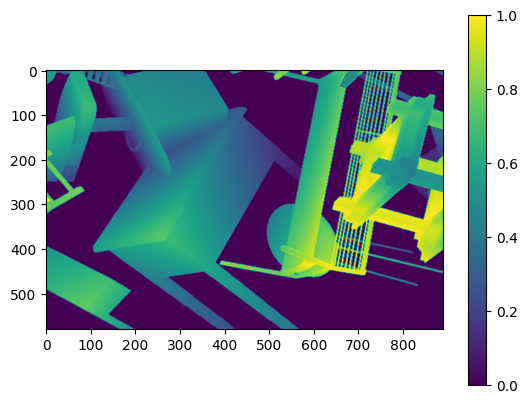

In [9]:
plt.imshow(weight_map[3].reshape(cam_H, cam_W), vmin = 0, vmax = 1), plt.colorbar()

#### Image formation

In [10]:
resized_psf.shape

(7, 24, 580, 890)

In [12]:
import torchvision
import torch.fft as fft

final_depth_image = torch.zeros(size=(len(depth_range), wvl_n, cam_H, cam_W))

for z in range(len(depth_range)):
    # bring sample
    hyp_psf = torch.tensor(resized_psf[z])
    hyp_gt = torch.tensor(hyp_shading).permute(2,0,1)

    # change to rgb by sensor CRF
    psf_hyp = hyp_psf / torch.sum(hyp_psf, dim=(-2, -1), keepdim=True)
    raw = fft.ifftshift(fft.ifft2(fft.fft2(fft.fftshift(hyp_gt)) * fft.fft2(fft.fftshift(psf_hyp.unsqueeze(0))))).real
    # raw = apply_srf(raw, cam_crf).squeeze().permute(1,2,0)
    # raw = raw/raw.max()
    raw_weighted = raw.squeeze() * torch.tensor(weight_map[z].reshape(580,890)).unsqueeze(dim = 0)
    final_depth_image[z] = raw_weighted

In [13]:
final_hyp_img = final_depth_image.sum(dim = 0)

In [14]:
final_hyp_img.shape, cam_crf.shape

(torch.Size([24, 580, 890]), torch.Size([24, 3]))

In [17]:
final_rgb_img = apply_srf(final_hyp_img.unsqueeze(dim = 0), cam_crf).squeeze().permute(1,2,0)
final_rgb_img = final_rgb_img / final_rgb_img.max()

(<matplotlib.image.AxesImage at 0x27a82fe8188>,
 (-0.5, 889.5, 579.5, -0.5),
 None)

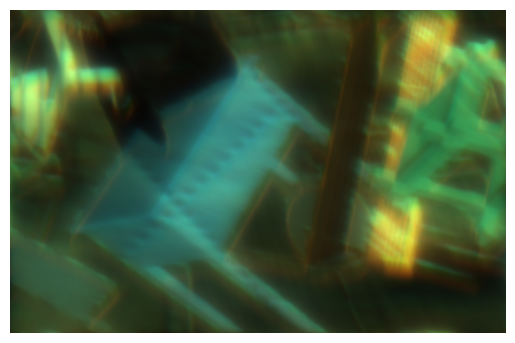

In [19]:
plt.imshow(final_rgb_img),plt.axis('off'), plt.savefig('doe_measurements.svg')

### Comparison

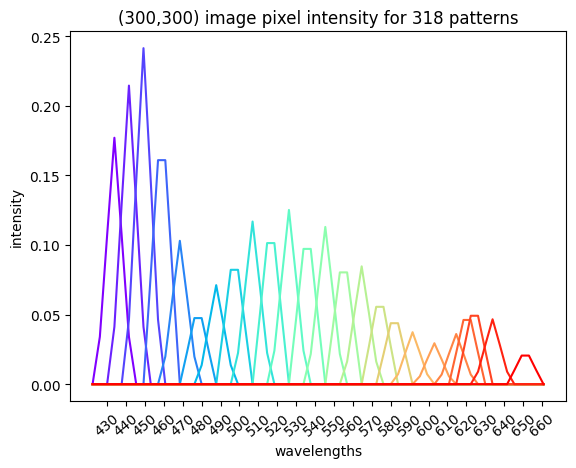

In [87]:
for i in range(24):
    plt.xticks(illum_x_ticks, illum_values, rotation = '40'), plt.plot(illum_ours[300,200,206:269,i], color = colors[i]), plt.xlabel('wavelengths'), plt.ylabel('intensity'), plt.title('(300,300) image pixel intensity for 318 patterns')


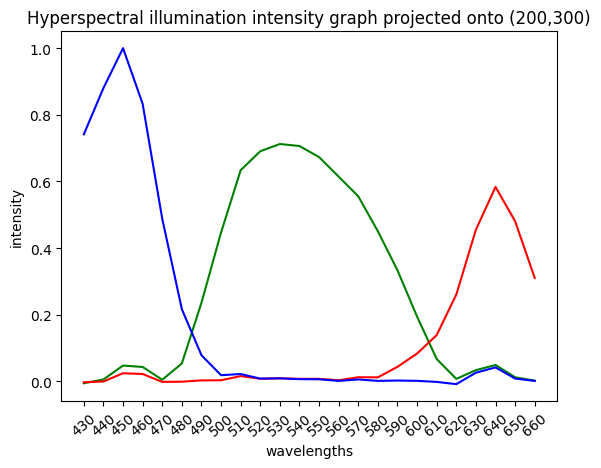

In [451]:
x, y = 200, 300
x_b, y_b = 300,300
x_g, y_g = 200, 300
x_r, y_r = 100, 300

x_ticks = [0, 1, 2]
values = ['red','green','blue']

# # blue captured_img_ours[y,x,232:297]
# illum_x_ticks = np.arange(2,63,2.6)
# illum_values = np.arange(430,670,10)

# green [300,200,206:269]
illum_x_ticks = np.arange(1,63,2.6)
illum_values = np.arange(430,670,10)

colors = plt.cm.rainbow(np.linspace(0, 1, 24))

plt.xticks(np.arange(0,24,1), illum_values, rotation = '40'),plt.plot(illum_deep[int(zero_uv1[y_g,x_g][0]),int(zero_uv1[y_g,x_g][1])], color = 'green', label = 'green color dot'), plt.xlabel('wavelengths'), plt.ylabel('intensity'), plt.title('Hyperspectral illumination intensity graph projected onto (%d,%d)'%(x_g, y_b))
plt.plot(illum_deep[int(zero_uv1[y_b,x_b][0]),int(zero_uv1[y_b,x_b][1])], color = 'red', label = 'green color dot')
plt.plot(illum_deep[int(zero_uv1[y_r,x_r][0]),int(zero_uv1[y_r,x_r][1])], color = 'blue', label = 'green color dot')

plt.savefig('illum_deep.svg')

In [118]:
normal.shape

(580, 890, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(<AxesSubplot:>,
 ([<matplotlib.axis.XTick at 0x1b455749908>,
  [Text(0, 0, 'red'), Text(1, 0, 'green'), Text(2, 0, 'blue')]),
 [<matplotlib.lines.Line2D at 0x1b455784d08>])

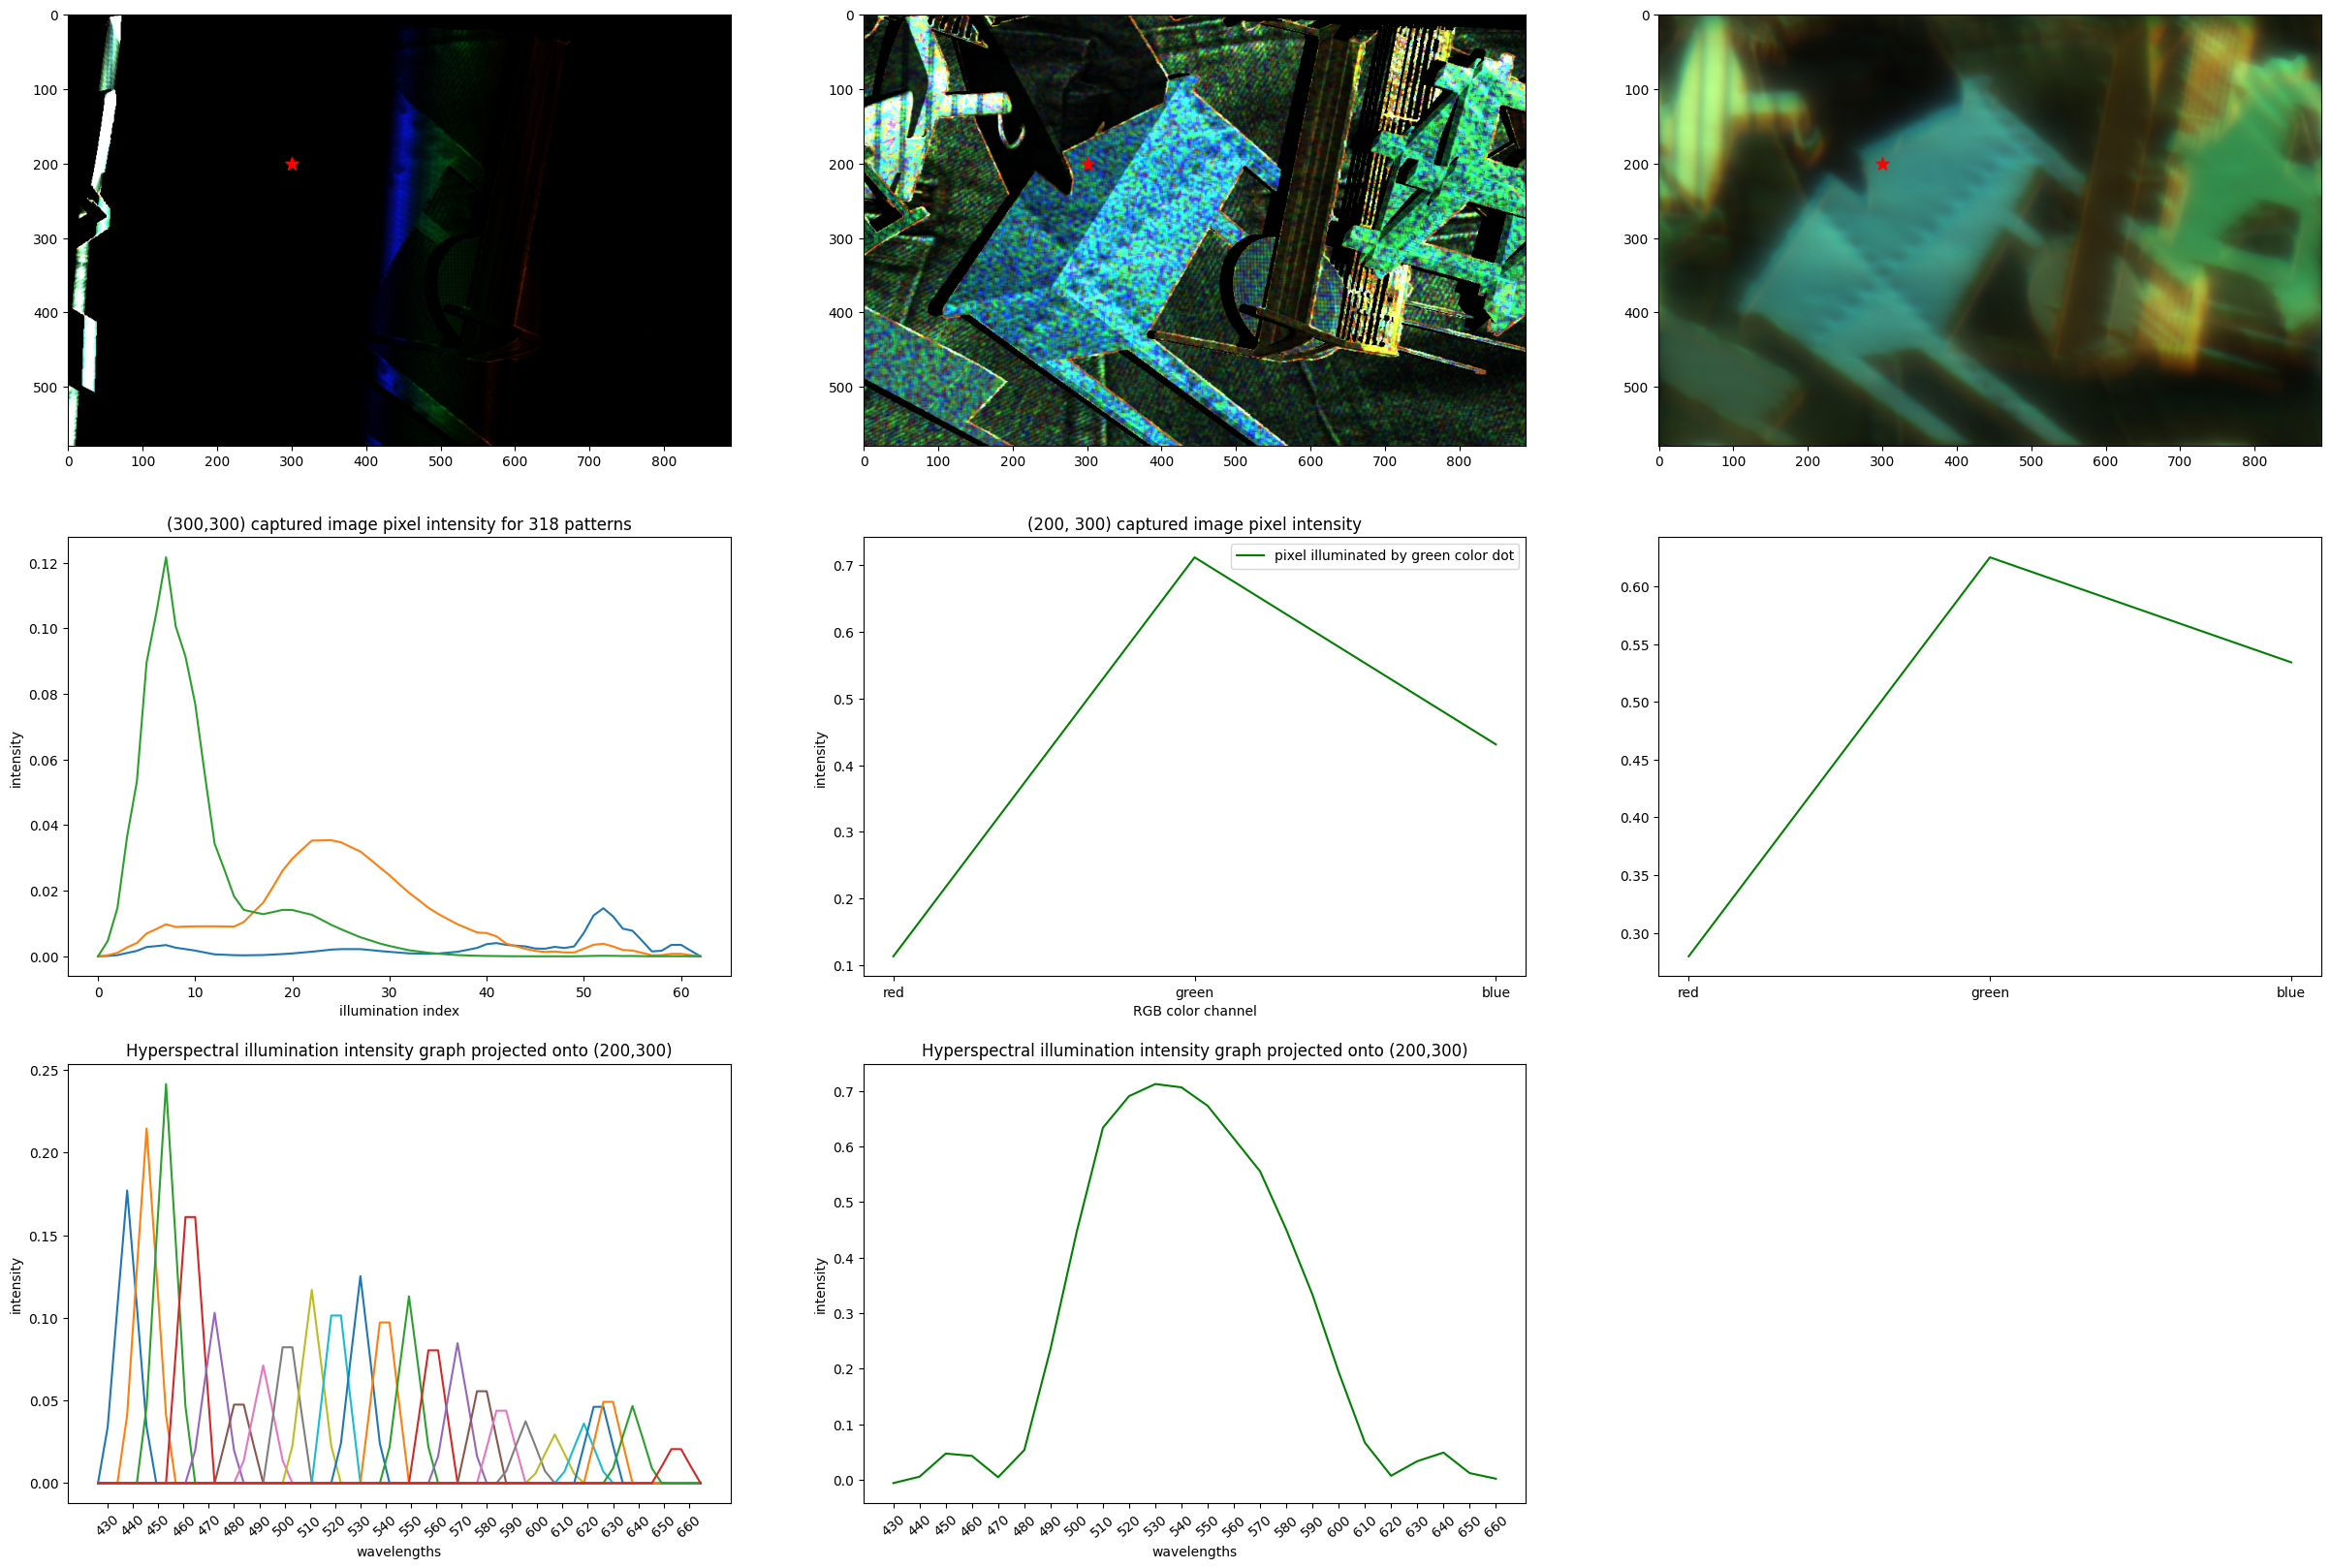

In [112]:
x, y = 200, 300
x_b, y_b = 300,300
x_g, y_g = 200, 300
x_r, y_r = 100, 300

x_ticks = [0, 1, 2]
values = ['red','green','blue']

# # blue captured_img_ours[y,x,232:297]
# illum_x_ticks = np.arange(2,63,2.6)
# illum_values = np.arange(430,670,10)

# green [300,200,206:269]
illum_x_ticks = np.arange(1,63,2.6)
illum_values = np.arange(430,670,10)

colors = plt.cm.rainbow(np.linspace(0, 1, 24))

plt.figure(figsize=(30, 20))

# captured images
plt.subplot(331),plt.imshow(captured_img_ours[:,:,60]*4), plt.scatter(y, x, s = 100, c = 'r', marker='*')
plt.subplot(332),plt.imshow(captured_img_deep), plt.scatter(y, x, s = 100, c = 'r', marker='*')
plt.subplot(333),plt.imshow(final_rgb_img.reshape), plt.scatter(y, x, s = 100, c = 'r', marker='*')

# Ours : captured image & illumination
plt.subplot(334),plt.plot(captured_img_ours[y,x,206:269]), plt.xlabel('illumination index'), plt.ylabel('intensity'), plt.title('(300,300) captured image pixel intensity for 318 patterns')
plt.subplot(337),plt.xticks(illum_x_ticks, illum_values, rotation = '40'), plt.plot(illum_ours[y,x,206:269]), plt.xlabel('wavelengths'), plt.ylabel('intensity'), plt.title('Hyperspectral illumination intensity graph projected onto (%d,%d)'%(x, y))

# Deep : captured image & illumination
# plt.subplot(335),plt.xticks(x_ticks, values), plt.plot(captured_img_deep[y_b,x_b], label = 'pixel illuminated by blue color dot'),plt.plot(captured_img_deep[y_g,x_g], label = 'pixel illuminated by green color dot'),plt.plot(captured_img_deep[y_r,x_r], label = 'pixel illuminated by red color dot'), plt.xlabel('RGB color channel'), plt.ylabel('intensity'), plt.title('3 pixel intensity'), plt.legend()
# plt.subplot(338),plt.xticks(np.arange(0,24,1), illum_values, rotation = '40'),plt.plot(illum_deep[int(zero_uv1[y_b,x_b][0]),int(zero_uv1[y_b,x_b][1])], label = 'blue color dot'), plt.plot(illum_deep[int(zero_uv1[y_g,x_g][0]),int(zero_uv1[y_g,x_g][1])], label = 'green color dot'), plt.plot(illum_deep[int(zero_uv1[y_r,x_r][0]),int(zero_uv1[y_r,x_r][1])], label = 'red color dot'), plt.xlabel('wavelengths'), plt.ylabel('intensity'), plt.title('3 pixel spectral graph of illuminated pattern')
plt.subplot(335),plt.xticks(x_ticks, values), plt.plot(captured_img_deep[y_g,x_g], label = 'pixel illuminated by green color dot', color = 'green'), plt.xlabel('RGB color channel'), plt.ylabel('intensity'), plt.title('(%d, %d) captured image pixel intensity'%(x_g, y_b)), plt.legend()
plt.subplot(338),plt.xticks(np.arange(0,24,1), illum_values, rotation = '40'),plt.plot(illum_deep[int(zero_uv1[y_g,x_g][0]),int(zero_uv1[y_b,x_b][1])], color = 'green', label = 'green color dot'), plt.xlabel('wavelengths'), plt.ylabel('intensity'), plt.title('Hyperspectral illumination intensity graph projected onto (%d,%d)'%(x_g, y_b))

# DOE : captured image & illumination
plt.subplot(336),plt.xticks(x_ticks, values), plt.plot(final_rgb_img[y_g,x_g], label = 'pixel illuminated by green color dot', color = 'green')#,plt.plot(final_rgb_img[y_g,x_g], label = 'pixel illuminated by green color dot'),plt.plot(final_rgb_img[y_r,x_r], label = 'pixel illuminated by red color dot'), plt.xlabel('RGB color channel'), plt.ylabel('intensity'), plt.title('3 pixel intensity'), plt.legend()

### [4] PSF visualization

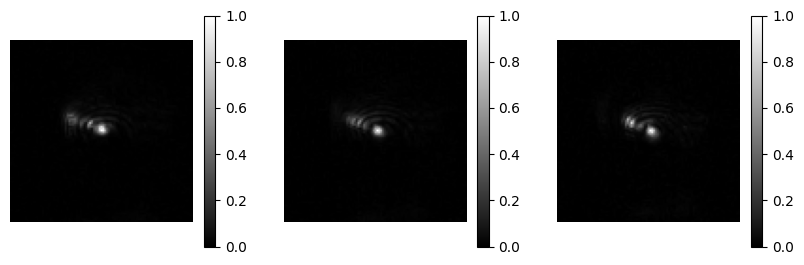

In [32]:
idx = 7
plt.figure(figsize=(10,3))
plt.subplot(131),plt.imshow(psfs[3,idx]/ psfs[3,idx].max(), cmap = 'gray'), plt.colorbar(), plt.axis('off')
plt.subplot(132),plt.imshow(psfs[4,idx]/ psfs[4,idx].max(), cmap = 'gray'), plt.colorbar(),plt.axis('off')
plt.subplot(133),plt.imshow(psfs[4,idx+1]/ psfs[4,idx+1].max(), cmap = 'gray'), plt.colorbar(),plt.axis('off')
# plt.show()
plt.savefig('psf_23.svg')

### Our depth decoding plotting

In [6]:
# depth comparison
capt_outs_depth_670 = np.load('./rebuttal/SOTA_methods/cam_N_img_zero_depth_0.67.npy')
capt_outs_depth_860 = np.load('./rebuttal/SOTA_methods/cam_N_img_zero_depth_0.86.npy')

(<AxesSubplot:>, (0.0, 0.5), [<matplotlib.lines.Line2D at 0x1848ec3ed48>])

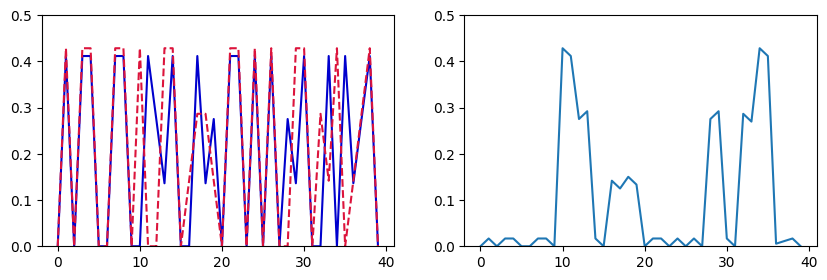

In [7]:
plt.figure(figsize = (10,3))
plt.subplot(121),plt.ylim([0,0.5]),plt.plot(capt_outs_depth_670[300,200].max(axis =1), c = 'mediumblue'), plt.plot(capt_outs_depth_860[300,200].max(axis =1), c = 'crimson', linestyle = '--')
plt.subplot(122),plt.ylim([0,0.5]),plt.plot(abs(capt_outs_depth_670[300,200].max(axis =1) - capt_outs_depth_860[300,200].max(axis =1)))

# plt.savefig('./depth_ours.svg')

### [23] Depth comparison

In [21]:
# depth
cam_N_img_deep_depth_670 = np.load('./rebuttal/SOTA_methods/cam_N_img_deep_depth_0.67.npy')
cam_N_img_deep_depth_860 = np.load('./rebuttal/SOTA_methods/cam_N_img_deep_depth_0.86.npy')
cam_N_img_deep_depth_comparison = np.load('./rebuttal/SOTA_methods/cam_N_img_deep_depth_comparison.npy')[:,:,0]

# illum
illum_deep = np.load('./rebuttal/SOTA_methods/illum_deep.npy')
illum_cam_deep = np.load('./rebuttal/SOTA_methods/illum_rgb_deep.npy')

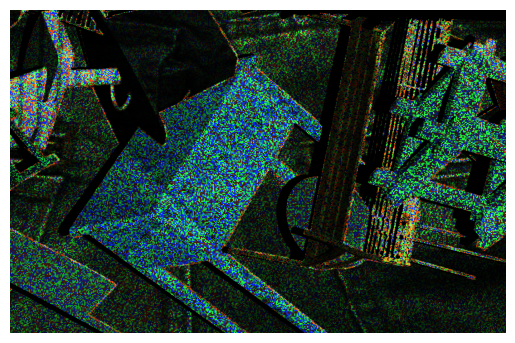

In [27]:
plt.imshow(cam_N_img_deep_depth_comparison), plt.axis('off')
plt.savefig('deep_capt.svg')

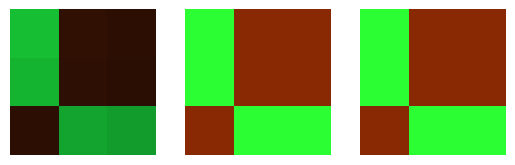

In [23]:
patch_size = 6
x, y = 250, 300
other_x, other_y = 248, 302

plt.subplot(131),plt.imshow(cam_N_img_deep_depth_comparison[y:y+patch_size//2,x:x+patch_size//2]), plt.axis('off')
plt.subplot(132),plt.imshow(illum_cam_deep[y:y+patch_size//2,x:x+patch_size//2]), plt.axis('off')
plt.subplot(133),plt.imshow(illum_cam_deep[other_y:other_y+patch_size//2,other_x:other_x+patch_size//2]), plt.axis('off')
plt.savefig('deep_depth_comparison.svg')

In [ ]:
x = np.arange(200, 300, 1)
y = np.arange(290, 310, 1)
patch_size = 6

for x_ in x:
    print(x_, 300)
    plt.figure()
    plt.imshow(illum_cam_deep[300:300+patch_size//2,x_:x_+patch_size//2])
    plt.show()

In [412]:
# depth comparison
capt_deep_depth_670 = np.load('./rebuttal/SOTA_methods/cam_N_img_deep_depth.npy')
capt_deep_depth_860 = np.load('./rebuttal/SOTA_methods/cam_N_img_deep_depth_0.19.npy')

(<AxesSubplot:title={'center':'difference of depth #1 and #2'}>,
 Text(0.5, 1.0, 'difference of depth #1 and #2'))

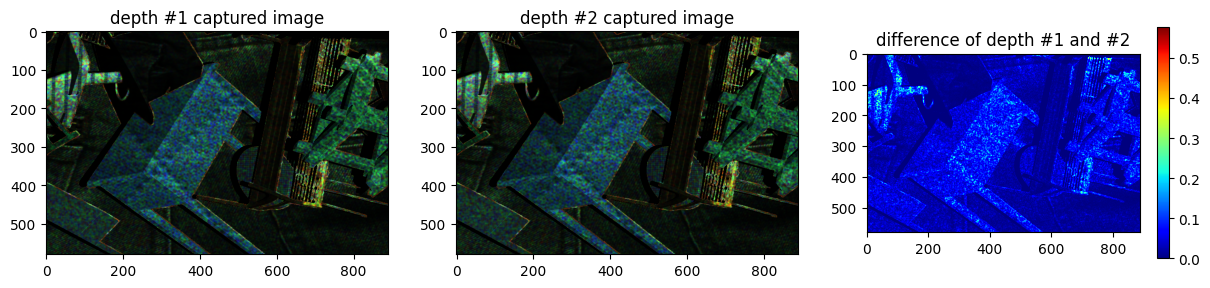

In [413]:
plt.figure(figsize=(15,3))
plt.subplot(131),plt.imshow((capt_deep_depth_670)), plt.title('depth #1 captured image')
plt.subplot(132),plt.imshow((capt_deep_depth_860)), plt.title('depth #2 captured image')
plt.subplot(133),plt.imshow(abs(capt_deep_depth_670 - capt_deep_depth_860).mean(axis = 2), cmap = 'jet'), plt.colorbar(), plt.title('difference of depth #1 and #2')

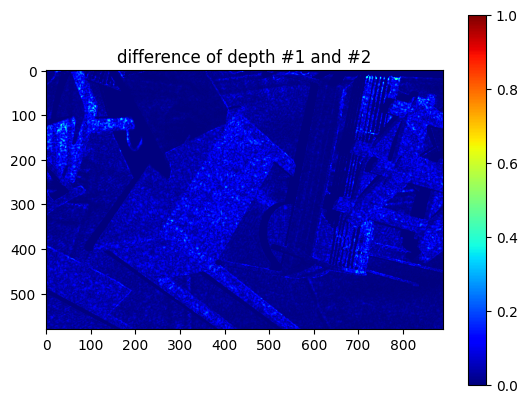

In [421]:
plt.imshow(abs(capt_deep_depth_670 - capt_deep_depth_860).mean(axis = 2), cmap = 'jet', vmin = 0, vmax = 1), plt.colorbar(), plt.title('difference of depth #1 and #2')
plt.savefig('depth_deep.svg')

In [414]:
# depth comparison
capt_ours_depth_670 = np.load('./rebuttal/SOTA_methods/cam_N_img_ours_depth.npy')
capt_ours_depth_860 = np.load('./rebuttal/SOTA_methods/cam_N_img_ours_depth_0.19.npy')

(<AxesSubplot:title={'center':'difference of depth #1 and #2'}>,
 Text(0.5, 1.0, 'difference of depth #1 and #2'))

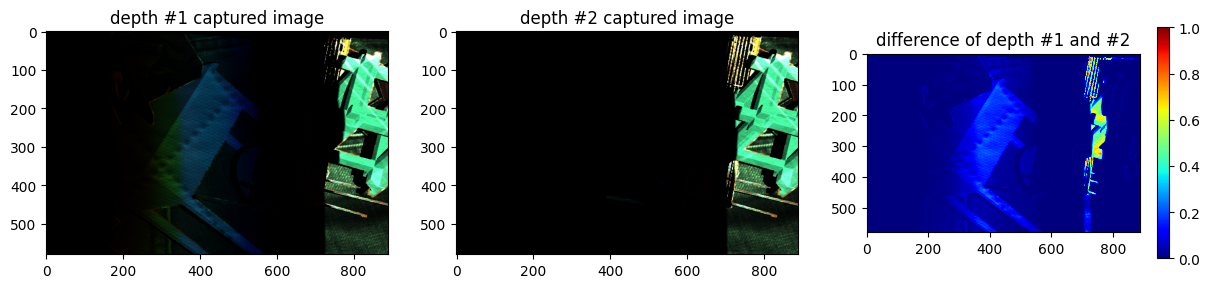

In [418]:
idx = 0
plt.figure(figsize=(15,3))
plt.subplot(131),plt.imshow((capt_ours_depth_670[:,:,idx])), plt.title('depth #1 captured image')
plt.subplot(132),plt.imshow((capt_ours_depth_860[:,:,idx])), plt.title('depth #2 captured image')
plt.subplot(133),plt.imshow(abs(capt_ours_depth_670[:,:,idx] - capt_ours_depth_860[:,:,idx]).mean(axis = 2), cmap = 'jet'), plt.colorbar(), plt.title('difference of depth #1 and #2')

## High-order diffraction illumination

In [35]:
def crop(img):
    start_x, start_y = 10, 77
    res_x, res_y = cam_W, cam_H
    img = img[start_y: start_y+res_y, start_x: start_x +res_x]
    
    return img

In [36]:
img_dir = './rebuttal/high_order_diffraction/'

# bring 160ms, intensity 20 image
exp160_int20_white_line = crop(cv2.imread('./rebuttal/high_order_diffraction/160ms_20_white_line/calibration00/capture_0005.png', -1)[:,:,::-1]/65535.)
exp160_int20_black = crop(cv2.imread('./rebuttal/high_order_diffraction/160ms_black/calibration00/capture_0000.png', -1)[:,:,::-1]/65535.)
exp160_int20 = (exp160_int20_white_line - exp160_int20_black)
cv2.imwrite('./rebuttal/high_order_diffraction/exp160_int20.png', exp160_int20*255.)

# bring 320ms, intensity 80 image
exp320_int80_white_line = crop(cv2.imread('./rebuttal/high_order_diffraction/320ms_80_white_line/calibration00/capture_0005.png', -1)[:,:,::-1]/65535.)
exp320_int80_black = crop(cv2.imread('./rebuttal/high_order_diffraction/320ms_black/calibration00/capture_0000.png', -1)[:,:,::-1]/65535.)
exp320_int80 = (exp320_int80_white_line - exp320_int80_black)
cv2.imwrite('./rebuttal/high_order_diffraction/exp320_int80.png', exp320_int80*255.)

# bring 1000ms, intensity 80 image
exp1000_int80_white_line = crop(cv2.imread('./rebuttal/high_order_diffraction/1000ms_80_white_line/calibration00/capture_0005.png', -1)[:,:,::-1]/65535.)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 889.5, 579.5, -0.5)

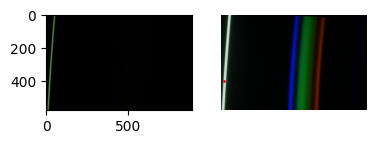

In [37]:
plt.subplot(131),plt.imshow(exp160_int20)
plt.subplot(132),plt.imshow(exp320_int80)
# plt.subplot(133),plt.imshow(exp1000_int80_white_line)

plt.scatter(20,400, s= 1, c = 'red')
plt.axis('off')

In [38]:
# # zero order point : 400, 20 (y, x) 
# print(exp160_int20_white_line[400,20]*255)
# print(exp160_int20[400,20]*255)

# first order point : 400, 430 (y, x) 
print(exp320_int80_white_line[400,430]*255)
print(exp320_int80[400,430]*255)

# # second order point : 400, 825 (y, x) 
# print(exp320_int80_white_line[400,825])
# print(exp320_int80_white_line[400,720])
# print(exp320_int80_black[400,825])
print(exp320_int80[400,825]*255)
# print(exp1000_int80_white_line[400,825])

[ 67.48638132  81.68093385 249.64980545]
[  6.97276265  17.9922179  205.19844358]
[1.61867704 2.98832685 8.59143969]


In [39]:
x_label = ['m = 0', 'm = -1', 'm = -2']
exp_160_int_20_y = [(exp160_int20[400,20]*255).max(), (exp160_int20[400,430].max()*255),  (exp160_int20[400,825].max()*255)]
exp_320_int_80_y = [(exp320_int80[400,20]*255).max(), (exp320_int80[400,430].max()*255),  (exp320_int80[400,825].max()*255)]

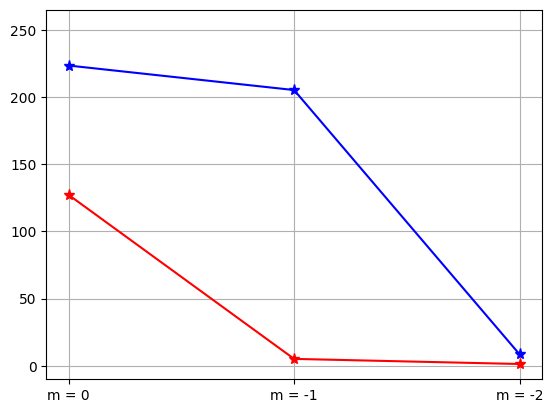

In [40]:
plt.ylim([-10,265])
plt.plot(x_label, exp_160_int_20_y, color = 'red', marker = '*', markersize = 8)
plt.plot(x_label, exp_320_int_80_y, color = 'blue', marker = '*', markersize = 8)
plt.grid()

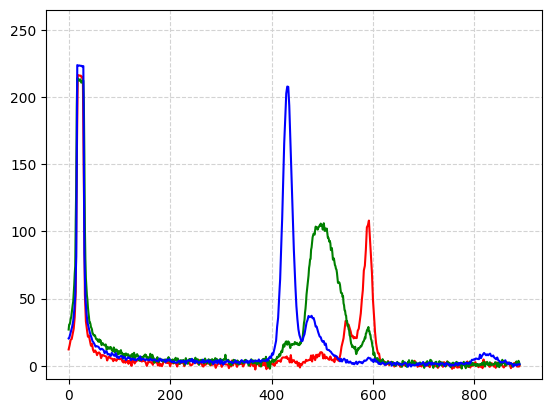

In [41]:
plt.ylim([-10,265])
plt.plot(exp320_int80[400,:,0]*255, c = 'r')
plt.plot(exp320_int80[400,:,1]*255, c = 'g')
plt.plot(exp320_int80[400,:,2]*255, c = 'b')
plt.grid(color = 'lightgray', linestyle = '--')
plt.savefig('320ms_80.svg')

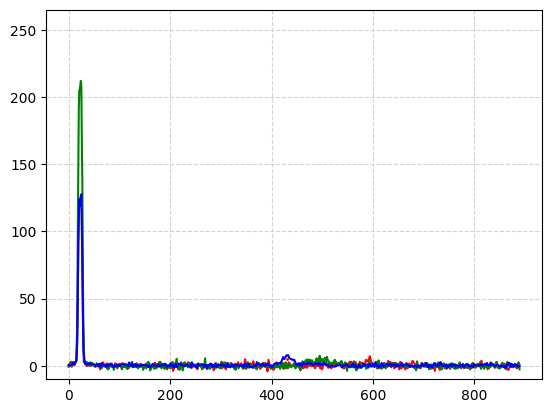

In [105]:
plt.ylim([-10,265])
plt.plot(exp160_int20[400,:,0]*255*1.5, c = 'r')
plt.plot(exp160_int20[400,:,1]*255*1.5, c = 'g')
plt.plot(exp160_int20[400,:,2]*255*1.5, c = 'b')
plt.scatter(431,0.020508125429159987*255, s =1, c = 'r')
plt.grid(color = 'lightgray', linestyle = '--')
plt.savefig('160ms_20.svg')

In [113]:
(exp160_int20[400,25,:])

array([0.32471199, 0.54590677, 0.33350118])

In [ ]:
plt.plot(exp160_int20[400,:,0]*255, c = 'r')
plt.plot(exp160_int20[400,:,1]*255, c = 'g')
plt.plot(exp160_int20[400,:,2]*255, c = 'b')

## Iterative Numerical Method Test

In [3]:
# device
device = 'cuda:0'

cam_coord = torch.tensor(cam_coord).type(torch.float32)
depth = torch.tensor(depth).type(torch.float32)
proj_focal_length = torch.tensor([0.008])

# calibrated params
def bring_params(camproj_calib_path, type):

    fs = cv2.FileStorage(camproj_calib_path, cv2.FileStorage_READ)
    img_shape = fs.getNode("img_shape").mat()
    cam_int = fs.getNode("cam_int").mat()
    cam_dist = fs.getNode("cam_dist").mat()
    proj_int = fs.getNode("proj_int").mat()
    proj_dist = fs.getNode("proj_dist").mat()
    cam_proj_rmat = fs.getNode("rotation").mat()
    cam_proj_tvec = fs.getNode("translation").mat()
    F = fs.getNode("fundamental").mat()
    E = fs.getNode("epipolar").mat()
    
    if type == "cam":
        return cam_int, cam_dist
    else:
        return proj_int, proj_dist, cam_proj_rmat, cam_proj_tvec

cam_int, cam_dist = bring_params('./calibration/calibration_propcam.xml', "cam")
proj_int,proj_dist, cam_proj_rmat, cam_proj_tvec = bring_params('./calibration/calibration_propcam.xml', "proj")

cam_int = torch.tensor(cam_int).type(torch.float32)
proj_int = torch.tensor(proj_int).type(torch.float32)

def extrinsic_proj_real():
    """ extrinsic_proj_real @ XYZ1 --> proj coord to world coord
    
    """
    extrinsic_proj_real = torch.zeros((4,4))
    
    extrinsic_proj_real[:3,:3] = torch.tensor(cam_proj_rmat).type(torch.float32)
    t_mtrx = torch.tensor(cam_proj_tvec).type(torch.float32)
    
    extrinsic_proj_real[:3,3:4] = t_mtrx*1e-3
    extrinsic_proj_real[3,3] = 1
    extrinsic_proj_real = torch.linalg.inv(extrinsic_proj_real)

    return extrinsic_proj_real

# camera unprojection
def unprojection(depth, cam_coord):
    """ Unproject camera sensor coord plane to world coord

        input : depth
        return : world coordinate X,Y,Z
    """
    
    suv1 = cam_coord*depth.unsqueeze(dim = 2)
    XYZ = torch.linalg.inv(cam_int)@(suv1.permute(2,0,1).reshape(3, -1))
    XYZ = XYZ. reshape(3, cam_H, cam_W)
    
    X, Y, Z = XYZ[0], XYZ[1], XYZ[2]
    
    return X, Y, Z

In [4]:
# arguments
wvls = torch.arange(420, 670, 10) * 1e-9
m_list = torch.tensor([-1, 0, 1])

X, Y, Z = unprojection(depth, cam_coord=cam_coord) # meter 단위
XYZ1 = torch.stack((X,Y,Z,torch.ones_like(X)), dim = 0)[:,100:460, 100:740]
XYZ1_proj = (torch.linalg.inv(extrinsic_proj_real())@XYZ1.reshape(4, -1)).reshape(4, 360, 640)[:3]

In [5]:
proj_H, proj_W = 360, 640
proj_H_linspace = torch.linspace(0, proj_H-1, proj_H)
proj_W_linspace = torch.linspace(0, proj_W-1, proj_W)

c, r = torch.meshgrid(proj_H_linspace, proj_W_linspace, indexing = 'ij') #  c : y, r: x
ones = torch.ones_like(c)

proj_centor = torch.zeros(size =(3, 1))

proj_uv1 = torch.stack((r, c, ones), dim = 2)

proj_suv = proj_focal_length * proj_uv1
xyz_p = (torch.linalg.inv(proj_int)@proj_suv.permute(0,2,1)).permute(0,2,1)

In [6]:
# camera unprojection
def unprojection(depth, cam_coord):
    """ Unproject camera sensor coord plane to world coord

        input : depth
        return : world coordinate X,Y,Z
    """
    
    suv1 = cam_coord*depth.unsqueeze(dim = 2)
    XYZ = torch.linalg.inv(cam_int)@(suv1.permute(0,2,1))
    
    X, Y, Z = XYZ[:,0,:], XYZ[:,1,:], XYZ[:,2,:]
    return X, Y, Z

# diffraction grating equation
def get_alpha_m(m, alpha_i, lmbda):

    d = (1/500)*1e-3
    m = torch.unsqueeze(m, dim=1)
    lmbda = torch.unsqueeze(lmbda, dim = 0)
    alpha_i = alpha_i.unsqueeze(dim = 0)
    m_l_d = m*lmbda/d 
    alpha_m = - m_l_d.unsqueeze(dim = 2) + alpha_i

    return alpha_m

def get_beta_m( beta_i):
    beta_m = beta_i

    return beta_m

def get_z_m(alpha_m, beta_m):
    z = torch.sqrt(1 - torch.clamp((alpha_m**2 + beta_m**2),0,0.99))

    return z

c:\Users\owner\anaconda3\envs\hyper3d\lib\site-packages\ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


 Epoch : 0/50000, Loss: 9.165236949920654, LR: 0.001


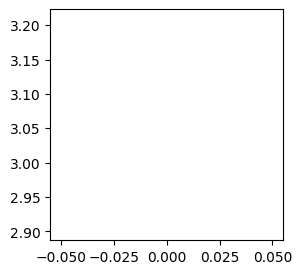

 Epoch : 100/50000, Loss: 8.4441819190979, LR: 0.001


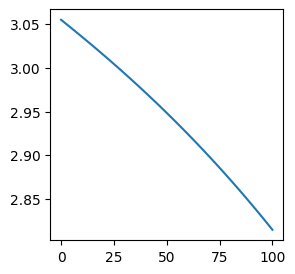

 Epoch : 200/50000, Loss: 7.2327775955200195, LR: 0.001


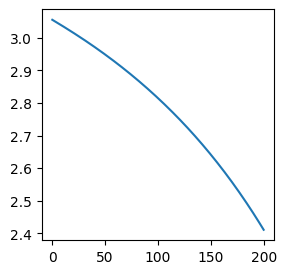

 Epoch : 300/50000, Loss: 5.071386694908142, LR: 0.001


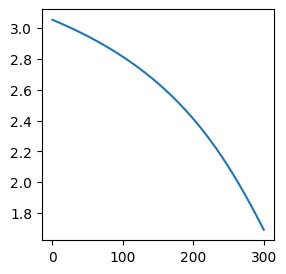

 Epoch : 400/50000, Loss: 1.5431926846504211, LR: 0.001


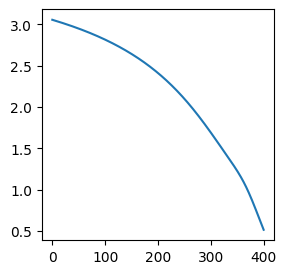

 Epoch : 500/50000, Loss: 0.013568724039942026, LR: 0.001


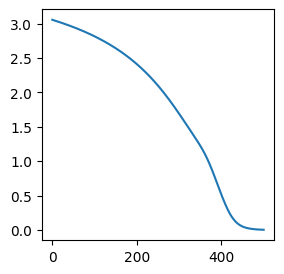

 Epoch : 600/50000, Loss: 0.0001550552769913338, LR: 0.001


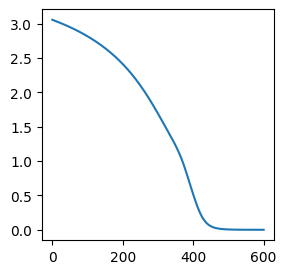

 Epoch : 700/50000, Loss: 1.8166774111705308e-06, LR: 0.001


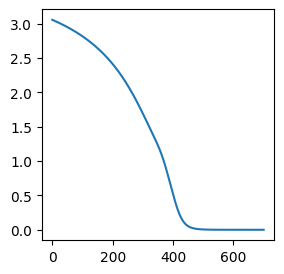

KeyboardInterrupt: 

In [10]:
mwvl_r = torch.ones(size = (3, len(m_list),len(wvls), proj_H, proj_W))*0.5

opt_param = torch.tensor(mwvl_r, dtype= torch.float, requires_grad=True, device= device)

# to device
proj_centor = proj_centor.to(device)
m_list = m_list.to(device)
wvls = wvls.to(device)
XYZ1_proj = XYZ1_proj.to(device)

# training args
lr = 1e-3 # 1e-3
decay_step = 1000 # 1000
epoch = 50000

# loss ftn
loss_f = torch.nn.MSELoss()
losses = []

optimizer = torch.optim.Adam([opt_param], lr = lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=decay_step, gamma = 0.8)
    
for i in range(epoch):        

    # define rt
    rt = (opt_param.reshape(3, -1) - proj_centor)
    rt_normalized = (rt/ rt.norm(dim = 0)).reshape(3, len(m_list), len(wvls), -1)
    
    # rP with diffraction grating equation
    alpha_m = get_alpha_m(m_list, rt_normalized[0], wvls).reshape(len(m_list), len(wvls), -1)
    beta_m = get_alpha_m(m_list, rt_normalized[1], wvls).reshape(len(m_list), len(wvls), -1)
    z = get_z_m(alpha_m, beta_m).reshape(len(m_list), len(wvls), -1)
    rP = torch.stack((alpha_m, beta_m, z), dim =0)
    rP = (rP/ rP.norm(dim = 0))
    
    # rP with calculation
    rP_cal = (XYZ1_proj.unsqueeze(dim = 1).unsqueeze(dim = 1) - opt_param).reshape(3, len(m_list), len(wvls), -1)
    rp_cal = (rP_cal / rP_cal.norm(dim = 0))
    
    # loss
    loss_patt = loss_f(rP.to(torch.float32), rp_cal.to(torch.float32))
    loss = (loss_patt)*3
    
    optimizer.zero_grad()
    loss.backward()
    losses.append(loss.item())
    optimizer.step()
    scheduler.step()
    
    if i % 100 == 0:
        print(f" Epoch : {i}/{epoch}, Loss: {loss.item()*3}, LR: {optimizer.param_groups[0]['lr']}")
        
        plt.figure(figsize = (3,3))
        plt.plot(losses)
        plt.show()

In [164]:
rP_cal.shape, rP.shape

(torch.Size([3, 3, 25, 230400]), torch.Size([3, 3, 25, 230400]))

In [172]:
loss_f(rP_cal.to(torch.float32), rP.to(torch.float32))

tensor(0.0849, device='cuda:0', grad_fn=<MseLossBackward0>)

In [175]:
rP_cal[:,0,0,0], rP[:,0,0,0]

(tensor([-0.0627, -0.1424,  1.0012], device='cuda:0', grad_fn=<SelectBackward0>),
 tensor([-0.0619, -0.1405,  0.9881], device='cuda:0', grad_fn=<SelectBackward0>))

In [158]:
XYZ1_proj.shape

torch.Size([3, 360, 640])

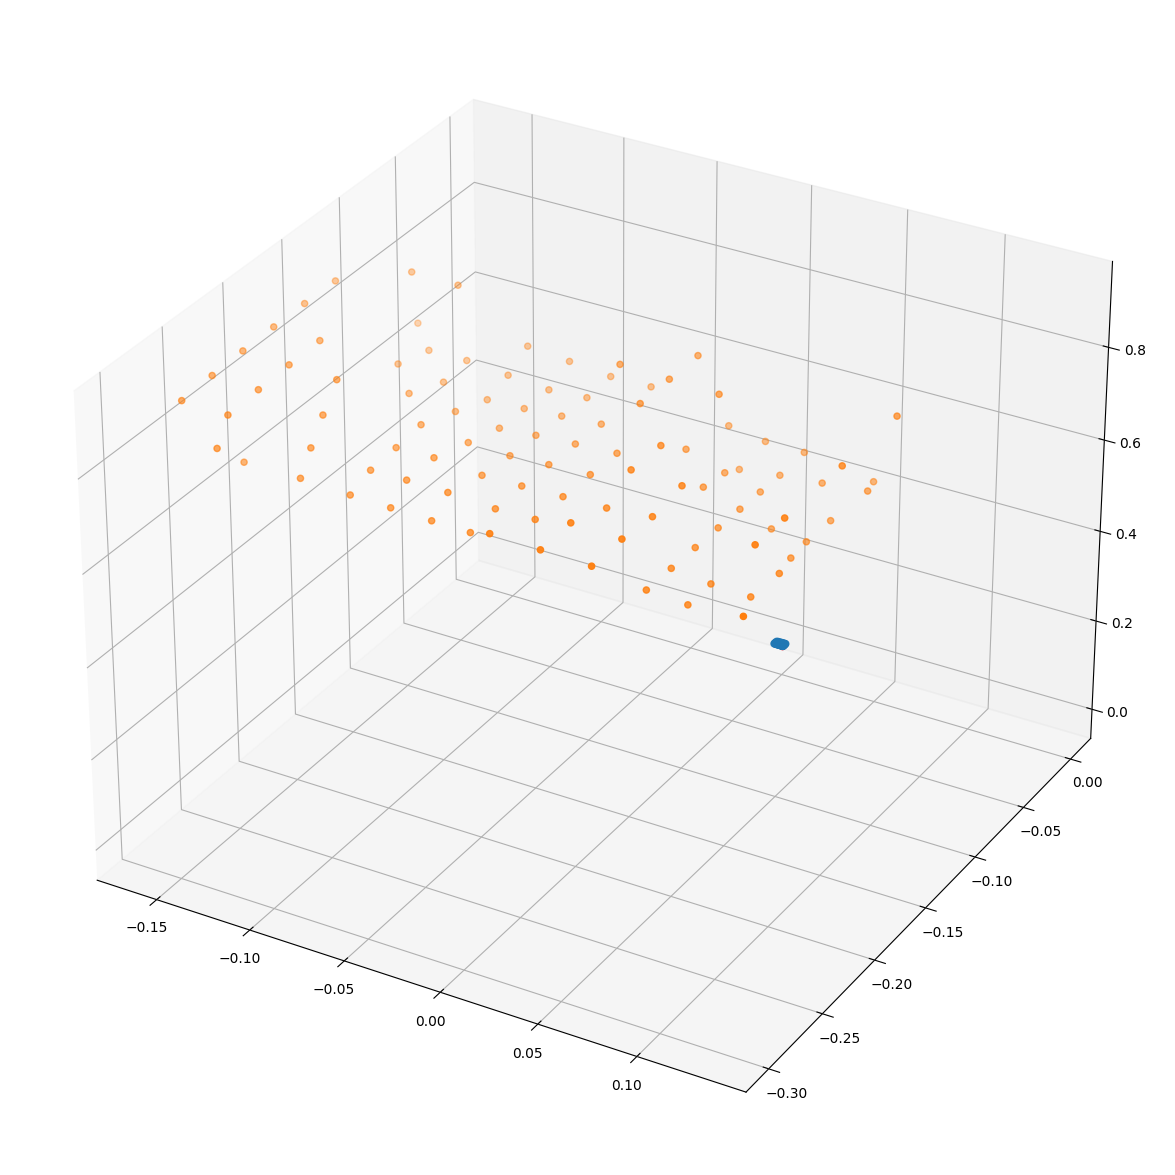

In [160]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(projection='3d')
XYZ1_proj = XYZ1_proj.detach().cpu()

ax.scatter(xyz_p[::50,::50,0], xyz_p[::50,::50,1], xyz_p[::50,::50,2])
ax.scatter(0,0,0, c = 'red')
ax.scatter(XYZ1_proj[0,::50,::50], XYZ1_proj[1,::50,::50], XYZ1_proj[2,::50,::50])

In [125]:
XYZ.shape

torch.Size([360, 640, 3])

In [118]:
xyz_p.shape

torch.Size([360, 640, 3])